# <center> Clasificación y Generación de Dígitos con la Base de datos MNIST <center>
    
    Nombres:
    Correo:

## 1) Ingreso de los Datos:

Ingreso de Módulos:

In [16]:
# inicialmente utilizamos los datos de keras, según digitalocean:
# https://www.digitalocean.com/community/tutorials/mnist-dataset-in-python
# También se pueden descargar de:
# https://www.kaggle.com/datasets/hojjatk/mnist-dataset
!(pip install keras)
!(pip install scikit-learn)
!(pip install tensorflow)
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd

### Cargamos los datos

Training: x_train (imágenes), y_train (características)
Test: x_test (imágenes), y_test (características)

Test:
Convertimos a numpy para poder llamar los elementos más fácilmente

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=np.array(x_train) 
y_train=np.array(y_train)
x_test=np.array(x_test)
y_test=np.array(y_test)
print('X_train: ',x_train.shape) # Indices: (Imagen i, fila j, columna k)
print('Y_train: ',y_train.shape)
print('X_test:  ',x_test.shape)
print('Y_test:  ',y_test.shape)

X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:   (10000, 28, 28)
Y_test:   (10000,)


Ejemplo de una imágen y su valor correspondiente:

Etiqueta: 5


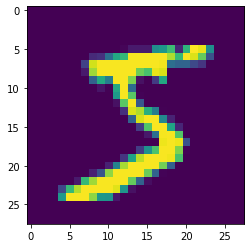

In [20]:
print("Etiqueta:",y_train[0])
plt.imshow(x_train[0])

## 2) Implementación del Modelo

Inicialmente intentamos con las funciones previamente implementadas de scikitlearn. Sin embargo, estas funciones reciben de entrada listas bidimensionales (nx1) por lo que intentamos aplanar las imágenes. Sin embargo veremos que los resultados no fueron los mejores

In [5]:
dim=x_train.shape # guardamos las dimensiones (elementos, imagen(fila,col))
x_train_p=x_train.reshape(dim[0],dim[1]*dim[2]) # aplanamos las imágenes
dim=x_test.shape
x_test_p=x_test.reshape(dim[0],dim[1]*dim[2])  # aplanamos las imágenes

In [23]:
nb_classifier = GaussianNB() #asumimos una distribución normal de los pixeles
nb_classifier.fit(x_train_p, y_train) # ajuste del modelo
y_pred = nb_classifier.predict(x_test_p) # valores predichos

Ejemplo de uno de los valores predichos

Valor predicho:  9


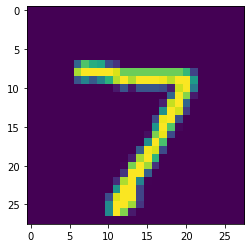

In [24]:
print("Valor predicho: ",y_pred[0])
plt.imshow(x_test[0])

In [25]:
accuracy = accuracy_score(y_test, y_pred)
print("Puntos etiquetados erróneamente de %d puntos : %d"
      % (x_test_p.shape[0], (y_test != y_pred).sum()))
print("Exactitud: ",accuracy)

Puntos etiquetados erróneamente de 10000 puntos : 4442
Exactitud:  0.5558


Vemos que el modelo tiene una exactitud del 55.58%, que no será tan buena como la que obtendremos al realizarlo manualmente.

### Naive Bayes Manual

Asumimos que en cada pixel la versimilitud sigue una distribución normal. Calculamos la probabilidad de que cada píxel en cada imagen de testeo corresponda al píxel promedio de un número dado (Función de verosimilitud o likelihood). Luego hallamos el dígito correspondiente a la máxima probabilidad.

En otras palabras, la verosimilitud de que la imagen $X_i$ corresponda con la característica/etiqueta $C_l$ se debe comparar pixel a pixel (pixeles independientes entre sí), de modo que viene dada por:

$$P(X_i| C_l)= \prod_{i=1}^{28\times28}\frac{1}{\sqrt{2\pi\sigma_i^2}} \exp{\left [ -\frac{(X_i-\mu_i)^2}{2\sigma_i^2}\right ]} $$

y la probabilidad de que sea $C_l$ es:
$$ P(C_l)=P(X_i| C_l)P(X_i)$$

Aplicamos log y sacamos el argumento (la inversa) para hallar $C_l$ que es la característica que queremos predecir de $X_i$:

$$ C_l=argmax(\log P(X_i| C_l)+\log P(X_i))$$
Vemos que $C_l$ aumenta con $P(X_i| C_l)$ y $P(X_i)$ por lo tanto solo hallaremos en el programa $\log P(X_i| C_l)$.

Promedios


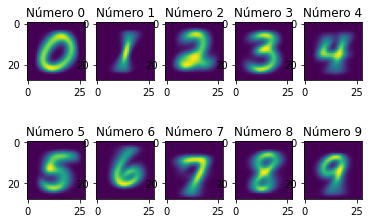

In [43]:
########################################
#Hallamos los parámetros mu y sigma para cada imagen a partir de los datos de entrenamiento
def estadisticos(x,y):
    dim=x.shape
    nums=np.unique(y)
    av=np.zeros((len(nums),dim[1],dim[2]))
    sigma=np.zeros((len(nums),dim[1],dim[2]))
    for i in np.unique(y):
    #     s+=len(x_train[y_train==i])
        av[i]=np.mean(x[y==i], axis=0) # Números promedio del training (por pixel)
        sigma[i]=np.std(x[y==i], axis=0) # desviaciones del training(por pixel) 
    return av, sigma
av,sigma=estadisticos(x_train,y_train)
print("Promedios")
fig, axs = plt.subplots(2, 5)
# Plot something in each subplot
for i, ax in enumerate(axs.flat):
    ax.imshow(av[i], label=f'Plot {i+1}')
    ax.set_title(f'Número {i}')

plt.show()


In [47]:
##########################################
# Método naive bayes para encontrar las características
def naive_bayes_mnist(x_train,y_train,x_test):
    av,sigma=estadisticos(x_train,y_train)
    log_p=np.zeros((len(x_test),len(nums))) # diez probabilidades por cada valor de testeo (una por cada número)
    y_pred=np.zeros(len(x_test))
    # la resta de la gaussiana se hace con el x_test porque son los valores que queremos predecir
    # mientras que las medias y las sigmas las hacemos con los datos de entrenamiento
    for i in range(len(x_test)):
        for l in nums:
            s_off=sigma[l]+10
            A=np.sqrt(2*np.pi*s_off**2)
            log_p[i,l]=np.sum(np.log(np.exp(-(x_test[i]-av[l])**2/(2*s_off**2))/A))
        y_pred[i]=np.argmax(log_p[i])
    return y_pred

In [48]:
y_pred=naive_bayes_mnist(x_train,y_train,x_test)

In [49]:
y_pred

array([7., 2., 1., ..., 9., 8., 6.])

## 3) Desempeño de Generalización del Problema de Clasificación
problem generalization performance

In [13]:
print("Puntos etiquetados erróneamente de %d puntos : %d"
      % (x_test_p.shape[0], (y_test != y_pred).sum()))

Puntos etiquetados erróneamente de 10000 puntos : 2619


Resultados de Principales Métricas de Clasificación

In [14]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = pd.DataFrame.from_dict(classification_report(y_test, y_pred,output_dict=True)).transpose()
print(f"Accuracy: {accuracy}")
report

Accuracy: 0.7381


,precision,recall,f1-score,support
0,0.905528,0.919388,0.912405,980.0000
1,0.762958,0.972687,0.855151,1135.0000
2,0.923430,0.584302,0.715727,1032.0000
3,0.797632,0.733663,0.764312,1010.0000
4,0.862888,0.480652,0.617397,982.0000
5,0.876607,0.382287,0.532397,892.0000
6,0.773124,0.924843,0.842205,958.0000
7,0.931701,0.703307,0.801552,1028.0000
8,0.531056,0.702259,0.604775,974.0000
9,0.506011,0.917740,0.652342,1009.0000


Matriz de Confusión

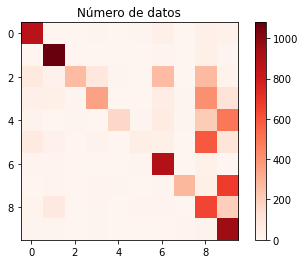

In [26]:
plt.imshow(confusion_matrix(y_test,y_pred),cmap='Reds')
plt.title("Número de datos")
plt.colorbar()